In [1]:
# 讀取Tokenizer
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(
    'meta-llama/Meta-Llama-3-8B-Instruct',
    trust_remote_code=True,
    add_special_tokens=False
)
tokenizer.pad_token = tokenizer.eos_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
system_format = {"role": "system", "content": '這是系統指令'}
question_format = {"role": "user", "content": '這是用戶的輸入'}
answer_format = {"role": "assistant", "content": '這是模型回復'}

chat_format = tokenizer.apply_chat_template([system_format, question_format, answer_format])
print(tokenizer.decode(chat_format))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

這是系統指令<|eot_id|><|start_header_id|>user<|end_header_id|>

這是用戶的輸入<|eot_id|><|start_header_id|>assistant<|end_header_id|>

這是模型回復<|eot_id|>


In [5]:
from transformers import BitsAndBytesConfig
import torch

quantization_params = {
            'load_in_4bit': True,
            'bnb_4bit_quant_type': "nf4",
            'bnb_4bit_use_double_quant': True,
            'bnb_4bit_compute_dtype': torch.bfloat16
        }
bnb_config = BitsAndBytesConfig(**quantization_params)

In [6]:
from accelerate import Accelerator
from transformers import AutoModelForCausalLM

device_map = {"": Accelerator().local_process_index}
model = AutoModelForCausalLM.from_pretrained(
        'meta-llama/Meta-Llama-3-8B-Instruct',
        quantization_config=bnb_config,
        torch_dtype=torch.bfloat16,
        device_map=device_map,
        use_cache=False,
    )
print(model)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Ll

In [7]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

peft_params = {
            'r': 32,        
            'target_modules': ["q_proj", "k_proj", "v_proj", "o_proj"],
            'lora_dropout': 0.1,
            'task_type': "CAUSAL_LM",
        }
peft_config = LoraConfig(**peft_params)

model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True) # QLora
model = get_peft_model(model, peft_config)
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4

In [9]:
from transformers.modeling_utils import unwrap_model

def activate_neftune(model, neftune_noise_alpha = 5):
        unwrapped_model = unwrap_model(model)
        embeddings = unwrapped_model.base_model.model.get_input_embeddings()
        embeddings.neftune_noise_alpha = neftune_noise_alpha
        # hook embedding layer
        hook_handle = embeddings.register_forward_hook(neftune_post_forward_hook)
        
        return model
        
def neftune_post_forward_hook(module, input, output):
    # 公式來源:https://github.com/neelsjain/NEFTune
    # 論文網址:https://arxiv.org/abs/2310.05914
    if module.training:
        dims = torch.tensor(output.size(1) * output.size(2))
        mag_norm = module.neftune_noise_alpha / torch.sqrt(dims)
        output = output + torch.zeros_like(output).uniform_(-mag_norm, mag_norm)
            
    return output
model = activate_neftune(model)


In [11]:
import pandas as pd

def transform_format(questions, answers, system='你是一個zh-tw版本的聊天機器人'):
    context = []
    for q, a in zip(questions, answers):
        system_format = {"role": "system", "content": system}
        question_format = {"role": "user", "content": q}
        answer_format = {"role": "assistant", "content": a}
        context.append([system_format, question_format, answer_format])
    return context

# 讀取CSV檔案
df = pd.read_csv('Gossiping-QA-Dataset-2_0.csv')

# 提取問題和答案的列表
questions = df['question'].tolist()[:5000]
answers = df['answer'].tolist()[:5000]

# 轉換格式
formatted_context = transform_format(questions, answers)

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader

# 定義自定義 Dataset
class PTTDataset(Dataset):
    def __init__(self, formatted_context, tokenizer):
        self.formatted_context = formatted_context
        self.tokenizer = tokenizer

    def __getitem__(self, index):
        return self.formatted_context[index]
       
    def __len__(self):
        return len(self.formatted_context)

    def collate_fn(self, batch):
        formatted_contexts = self.tokenizer.apply_chat_template(batch, padding=True, return_dict=True, max_length=8192, return_tensors='pt', truncation=True)
        attention_mask = formatted_contexts['attention_mask']
        labels = formatted_contexts['input_ids'].clone()
        labels[attention_mask == 0] = -100
        formatted_contexts['labels'] = labels
        return formatted_contexts

# 建立資料集
trainset = PTTDataset(formatted_context, tokenizer)
validset = PTTDataset(formatted_context, tokenizer)

# 創建 DataLoader
train_loader = DataLoader(trainset, batch_size=4, shuffle=True, collate_fn=trainset.collate_fn)
valid_loader = DataLoader(validset, batch_size=4, shuffle=True, collate_fn=validset.collate_fn)

In [13]:
import torch.optim as optim
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup

# 訓練設置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=len(train_loader) * 0.2, 
        num_training_steps=len(train_loader) * 10, 
        num_cycles=1, 
)

  0%|          | 0/1250 [00:00<?, ?it/s]c:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\models\llama\modeling_llama.py:648: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Valid Epoch 0: 100%|██████████| 1250/1250 [04:08<00:00,  5.04it/s, loss=2.036

Saving Model With Loss 2.05673
Train Loss: 2.69410| Valid Loss: 2.05673| Best Loss: 2.05673



Valid Epoch 1: 100%|██████████| 1250/1250 [04:08<00:00,  5.02it/s, loss=2.275]


Saving Model With Loss 2.01128
Train Loss: 2.10769| Valid Loss: 2.01128| Best Loss: 2.01128



Valid Epoch 2: 100%|██████████| 1250/1250 [04:07<00:00,  5.04it/s, loss=1.897]


Saving Model With Loss 1.96214
Train Loss: 2.04977| Valid Loss: 1.96214| Best Loss: 1.96214



Valid Epoch 3: 100%|██████████| 1250/1250 [04:07<00:00,  5.04it/s, loss=1.659]


Saving Model With Loss 1.92267
Train Loss: 1.99899| Valid Loss: 1.92267| Best Loss: 1.92267



Valid Epoch 4: 100%|██████████| 1250/1250 [04:07<00:00,  5.05it/s, loss=1.752]


Saving Model With Loss 1.88155
Train Loss: 1.95486| Valid Loss: 1.88155| Best Loss: 1.88155



Valid Epoch 5: 100%|██████████| 1250/1250 [04:07<00:00,  5.04it/s, loss=1.406]


Saving Model With Loss 1.84768
Train Loss: 1.91468| Valid Loss: 1.84768| Best Loss: 1.84768



Valid Epoch 6: 100%|██████████| 1250/1250 [04:08<00:00,  5.04it/s, loss=1.585]


Saving Model With Loss 1.82579
Train Loss: 1.88240| Valid Loss: 1.82579| Best Loss: 1.82579



Valid Epoch 7: 100%|██████████| 1250/1250 [04:07<00:00,  5.05it/s, loss=1.443]


Saving Model With Loss 1.80940
Train Loss: 1.85575| Valid Loss: 1.80940| Best Loss: 1.80940



Valid Epoch 8: 100%|██████████| 1250/1250 [04:07<00:00,  5.04it/s, loss=1.828]


Saving Model With Loss 1.80488
Train Loss: 1.83953| Valid Loss: 1.80488| Best Loss: 1.80488



Valid Epoch 9: 100%|██████████| 1250/1250 [04:07<00:00,  5.04it/s, loss=2.114]


Saving Model With Loss 1.80411
Train Loss: 1.83201| Valid Loss: 1.80411| Best Loss: 1.80411



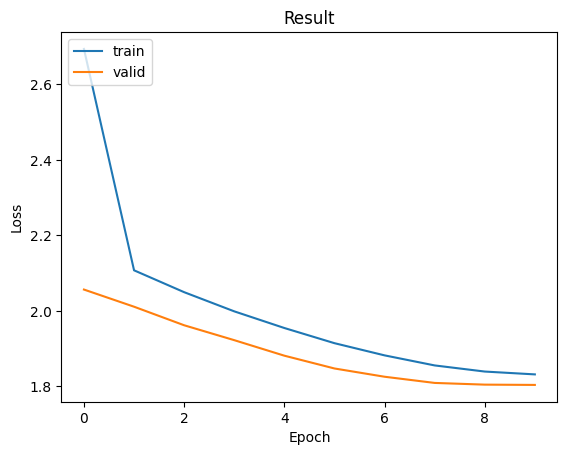

In [6]:
from trainer import Trainer
trainer = Trainer(
    epochs=10, 
    train_loader=train_loader, 
    valid_loader=valid_loader,
    model=model, 
    optimizer=[optimizer],
    scheduler=[scheduler],
    early_stopping=3,
    device=device
)
trainer.train()

In [15]:
model.load_state_dict(torch.load('model.ckpt'))
model.eval()
model.generation_config.pad_token_id = tokenizer.eos_token_id

In [24]:
messages = [
    {"role": "system", "content": '你是一個zh-tw版本的聊天機器人'},
    {"role": "user", "content": 'PTT是甚麼阿?'},
]
input_data = tokenizer.apply_chat_template(messages, padding=True, return_dict=True, max_length=8192, return_tensors='pt', truncation=True).to(device)
ids = model.generate(**input_data)
print(tokenizer.decode(ids[0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

你是一個zh-tw版本的聊天機器人<|eot_id|><|start_header_id|>user<|end_header_id|>

PTT是甚麼阿?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

PTT是台灣最大的網路論壇<|eot_id|>
